<a href="https://colab.research.google.com/github/anantoj/csgo-round-winner-classification/blob/main/csgo_round_winner_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# dataset link: https://www.kaggle.com/christianlillelund/csgo-round-winner-classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

# Data Loading

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/csgo_round_snapshots.csv')
df.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,...,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,650.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,10750.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


In [ ]:
df.columns

Index(['time_left', 'ct_score', 't_score', 'map', 'bomb_planted', 'ct_health',
       't_health', 'ct_armor', 't_armor', 'ct_money', 't_money', 'ct_helmets',
       't_helmets', 'ct_defuse_kits', 'ct_players_alive', 't_players_alive',
       'ct_weapon_ak47', 't_weapon_ak47', 'ct_weapon_aug', 't_weapon_aug',
       'ct_weapon_awp', 't_weapon_awp', 'ct_weapon_bizon', 't_weapon_bizon',
       'ct_weapon_cz75auto', 't_weapon_cz75auto', 'ct_weapon_elite',
       't_weapon_elite', 'ct_weapon_famas', 't_weapon_famas',
       'ct_weapon_g3sg1', 't_weapon_g3sg1', 'ct_weapon_galilar',
       't_weapon_galilar', 'ct_weapon_glock', 't_weapon_glock',
       'ct_weapon_m249', 't_weapon_m249', 'ct_weapon_m4a1s', 't_weapon_m4a1s',
       'ct_weapon_m4a4', 't_weapon_m4a4', 'ct_weapon_mac10', 't_weapon_mac10',
       'ct_weapon_mag7', 't_weapon_mag7', 'ct_weapon_mp5sd', 't_weapon_mp5sd',
       'ct_weapon_mp7', 't_weapon_mp7', 'ct_weapon_mp9', 't_weapon_mp9',
       'ct_weapon_negev', 't_weapon_negev',

In [ ]:
df.isnull().sum()

time_left                    0
ct_score                     0
t_score                      0
map                          0
bomb_planted                 0
                            ..
ct_grenade_molotovgrenade    0
t_grenade_molotovgrenade     0
ct_grenade_decoygrenade      0
t_grenade_decoygrenade       0
round_winner                 0
Length: 97, dtype: int64

# Data Exploration

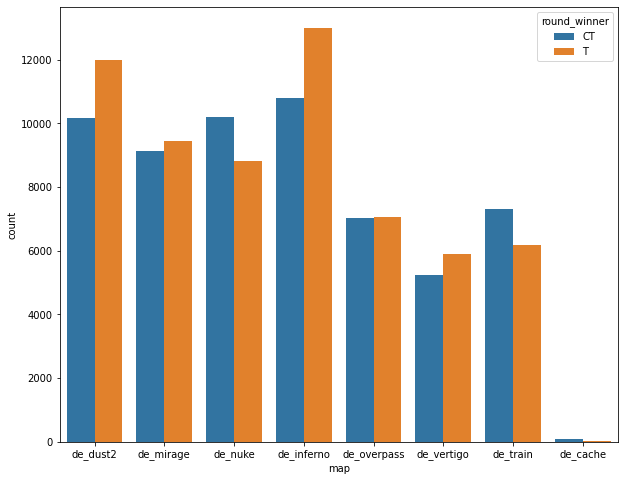

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(x="map", hue="round_winner", data=df)
plt.show()

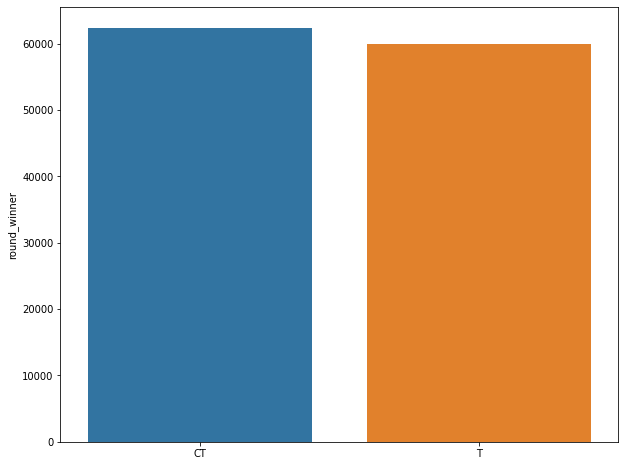

In [ ]:
plt.figure(figsize=(10,8))
ax = sns.barplot(x=df['round_winner'].unique(), y=df['round_winner'].value_counts())
plt.show()

# Preprocessing

## 1. Drop single-valued data

In [ ]:
single_cols=[]
for i, col in enumerate(df.columns):
    if (df[col].nunique() == 1):
        single_cols.append(df.columns[i])

single_cols

['ct_weapon_bizon',
 'ct_weapon_g3sg1',
 't_weapon_m249',
 'ct_weapon_negev',
 'ct_weapon_r8revolver',
 'ct_weapon_sawedoff']

In [ ]:
for col in single_cols:
    df.drop(col, axis = 1, inplace=True)

## 2. Encode Non-Numeric Data

In [ ]:
non_numeric = [col for col in df.columns if df[col].dtype != 'float64']
non_numeric

['map', 'bomb_planted', 'round_winner']

In [ ]:
for i, col in enumerate(non_numeric):
    print(non_numeric[i], df[col].nunique())

map 8
bomb_planted 2
round_winner 2


In [ ]:
label_encoder = LabelEncoder() 
df['bomb_planted'] = label_encoder.fit_transform(df['bomb_planted'])
df['round_winner'] = label_encoder.fit_transform(df['round_winner'])

In [ ]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(df[['map']]))
df = df.join(OH_cols)
df.drop(['map'], axis=1, inplace = True)

## 3. Scaling

In [ ]:
X = df.drop('round_winner', axis = 1)
y = df['round_winner']

In [ ]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
# X = X_scaled

# Feature Engineering

## 1. Principal Component Analysis

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,...,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97
0,-3.181948,-2.954751,-2.750634,0.419014,-0.618952,-1.066988,1.115937,0.070672,0.977854,-1.338538,-0.333602,0.687606,0.156578,1.186669,0.254005,-0.084086,-0.071685,-0.707243,-0.254087,0.601665,0.022462,0.321269,0.123173,-0.139716,-0.269491,0.190974,0.279555,-0.008988,-0.142729,0.020432,-0.113126,0.261581,0.153410,-0.199422,0.206818,-0.158336,-0.068393,-0.243535,0.192559,0.134927,...,0.077050,0.560537,-0.411322,-0.884237,0.053119,-0.476668,-0.693664,0.133880,0.240844,-0.148580,-0.058355,-0.495870,-0.194765,0.087047,-0.144695,-0.113078,0.239745,-0.162615,0.004181,-0.343576,0.141824,0.051097,-0.016692,-0.195264,-0.316084,0.273321,-0.676258,-0.158170,-0.196624,-0.264710,-0.130958,-0.556207,-0.218045,-0.088013,0.043670,-0.091525,0.025743,0.006385,-0.004076,-1.182844e-14
1,-1.967964,-2.214297,-2.311403,0.873147,-0.920870,-1.482156,1.289954,0.114345,0.896894,-1.315876,-0.406429,0.810792,0.143899,0.989523,0.289531,-0.066215,-0.152443,-1.049210,0.261524,0.796291,-0.106502,0.296207,0.291525,-0.221213,-0.326634,0.315796,0.279996,-0.100908,-0.290771,-0.081761,-0.193043,0.283521,0.131110,-0.286998,0.225120,-0.127757,-0.027741,-0.243205,0.251473,0.084186,...,0.162023,0.650679,-0.130558,-0.756916,0.015658,-0.322939,-0.627205,0.267568,0.308160,0.156444,-0.196255,-0.417977,-0.161390,0.317021,-0.116102,-0.127835,0.432834,-0.305459,0.354668,-0.315275,-0.124639,0.046775,0.003093,-0.234866,0.220543,-0.419160,0.500438,0.268570,0.582617,0.144030,0.967036,0.588888,0.262798,-0.006944,0.021428,0.035886,-0.026405,0.024795,0.003126,-3.615813e-14
2,-3.058027,-1.219712,-1.094867,0.637028,-0.934784,-1.437850,0.997828,0.154815,1.027144,-1.211282,-0.366699,1.383293,0.258394,0.078724,0.300605,-0.012618,0.025902,-0.084056,0.517557,0.112034,0.001429,-0.035374,0.212121,-0.203285,-0.106966,0.047832,0.249371,-0.069080,-0.169922,-0.037682,-0.159550,0.237383,0.062202,-0.080885,0.071214,-0.062646,-0.037518,-0.146372,0.171420,-0.057043,...,-0.371474,0.046282,-0.259304,-0.247129,-0.009366,0.137717,-0.735725,0.302036,0.539625,-0.303238,0.049903,-0.575545,-0.242441,0.060975,-0.121987,-0.037258,0.329215,-0.215778,-0.120073,-0.349040,-0.007643,0.340408,-0.047246,-0.290658,0.282391,-0.354809,0.520040,0.163577,0.523968,-0.157660,0.902329,-0.059972,0.320867,-0.043226,-0.104379,-0.048400,-0.043980,0.014685,0.002020,-5.098501e-15
3,-3.533879,-0.899341,-1.068402,1.399231,-0.753201,-0.876778,2.106459,2.022555,0.715638,-1.539011,0.506339,-0.068921,-0.621410,4.421832,0.303711,-0.300534,0.561611,-4.183338,-2.630892,1.080458,0.348271,0.890265,-0.101902,1.400068,-1.609677,0.308179,-0.496215,0.658593,1.975415,0.363500,-0.005923,0.680315,-0.512239,-0.455008,0.616640,0.271573,0.069695,0.270704,-0.967206,-0.463508,...,-3.302258,-2.436501,0.375778,4.639278,-0.794149,3.168360,0.709286,0.814510,1.897000,-1.655840,1.053139,-0.763667,-0.168304,-0.799217,-0.018582,-0.276805,0.199550,0.091216,0.280262,-0.350996,0.150798,0.515774,0.055102,-0.072913,0.298987,-0.474166,0.660324,-0.056625,0.095558,0.196348,0.260106,-0.293562,0.272206,-0.170885,-0.173045,-0.039974,-0.047218,0.012940,0.001079,8.582031e-15
4,-2.666074,-3.365521,-2.443015,0.165078,-0.167550,-0.750443,1.190205,0.020577,0.875280,-1.298618,-0.370676,0.698339,0.120114,1.171065,0.227297,-0.009390,-0.041338,-0.654486,-0.449266,0.601308,-0.100767,0.268643,0.017480,-0.260303,-0.230712,0.108809,0.295272,0.024938,-0.179186,0.005151,-0.196377,0.245667,0.039651,-0.098894,0.175395,-0.128763,-0.034461,-0.222854,0.149478,0.159669,...,0.187973,0.306572,-0.471429,-0.776326,0.198545,-0.629793,-0.411736,0.010182,-0.011808,-0.115179,-0.066994,-0.286422,-0.138412,0.0004

In [ ]:
def plot_variance(pca, width=8, dpi=100):
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)

    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )

    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )

    fig.set(figwidth=8, dpi=100)
    return axs

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a80583890>,
      dtype=object)

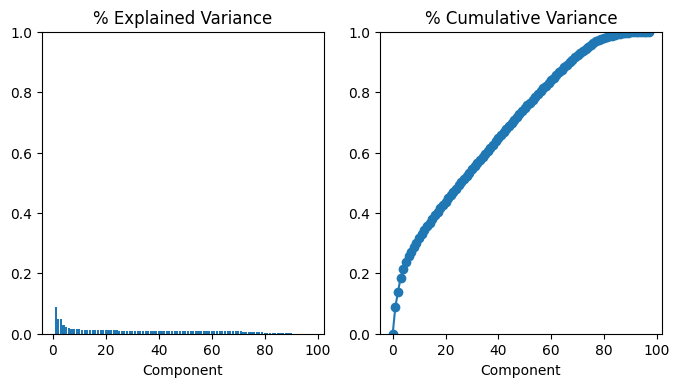

In [ ]:
plot_variance(pca)

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=component_names,  
    index=X.columns, 
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,...,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97
time_left,0.079272,-0.296570,-0.262686,-0.019010,0.052635,0.063037,-0.024958,0.008331,0.019825,-0.007947,0.032319,-0.011294,-0.004309,0.036212,-0.004813,-0.016284,0.009826,0.032672,-0.026513,-0.029990,0.076185,0.013282,-0.006530,0.037597,-0.000715,-0.012288,0.021953,0.018345,0.024855,0.028556,0.021313,0.011295,0.031544,0.006012,0.004146,-0.015405,-0.018202,-0.006056,-0.002762,0.015390,...,-0.067235,0.034066,-0.050089,-0.049165,0.011601,-0.008610,-0.105374,-0.008253,0.023970,-0.067574,0.065820,-0.033048,-0.043585,-0.029552,-0.037426,-0.021627,0.029080,0.047923,-0.071627,0.067758,0.020103,-0.058352,-0.126947,-0.128707,-0.142209,0.143980,-0.299279,0.047810,0.058712,0.265522,-0.038961,0.645442,-0.261568,-0.000467,0.047813,0.043185,0.030585,0.006246,0.001742,3.455030e-17
ct_score,0.061509,-0.020135,0.093436,-0.248581,0.127751,0.170486,0.163169,-0.013397,-0.297997,0.380175,0.053193,-0.102873,0.186635,-0.026791,0.014345,0.018355,0.040242,-0.031291,0.081878,-0.030364,0.023121,-0.031452,0.049297,0.066105,0.015925,-0.065456,-0.021947,0.013925,-0.003396,-0.007408,0.007114,-0.007379,0.010885,-0.016367,0.009597,-0.002655,0.017995,0.008759,-0.014214,-0.032143,...,-0.035671,0.070327,0.032967,-0.007245,0.006441,0.039549,-0.091416,0.030679,0.053818,0.061629,0.046665,-0.074003,0.003438,0.072189,-0.016419,0.029176,0.091667,0.028390,0.018970,-0.091118,0.277713,-0.198479,-0.339325,0.438652,0.042425,-0.167805,-0.113681,-0.035596,0.031112,-0.007764,0.030570,-0.005925,0.025164,0.010141,-0.001162,-0.004184,0.004735,-0.000957,-0.000253,3.419151e-17
t_score,0.046022,0.040109,0.013824,-0.274116,0.047035,0.232822,0.128507,0.053255,-0.322961,0.419929,0.062458,-0.069650,0.083616,0.005373,-0.000445,0.028302,-0.000259,-0.036373,0.050416,-0.040187,0.094841,-0.045327,0.051531,0.038993,0.005672,-0.042127,-0.021946,0.014224,0.005326,-0.005207,0.000669,-0.041457,0.007334,-0.005143,0.006262,0.002500,0.015840,0.019202,-0.006710,-0.019768,...,0.008058,0.045144,0.036681,-0.015522,0.014942,0.000586,-0.037171,-0.000168,0.033029,0.029419,0.032654,-0.032257,0.010946,0.059248,-0.042331,-0.063774,0.065736,-0.028565,0.059984,0.106093,-0.292456,0.211435,0.330058,-0.419676,-0.052036,0.183805,0.111645,0.041358,-0.029597,-0.023225,-0.031589,-0.018467,-0.019371,-0.013569,0.005832,0.001009,-0.002080,0.000309,0.000377,-6.601222e-17
bomb_planted,-0.151563,0.164319,0.138957,-0.076472,0.005059,-0.057949,-0.036395,-0.004314,0.034984,-0.014556,-0.023841,-0.023173,0.136994,0.052728,0.040828,-0.042807,0.011237,0.076768,-0.141896,-0.051346,0.024497,0.077922,0.029563,0.068181,0.015322,0.027067,-0.059617,0.029094,0.079092,-0.011871,0.059638,-0.032173,0.025560,0.014206,-0.011652,-0.014851,-0.026946,0.019208,-0.016267,-0.000743,...,0.076699,0.081067,-0.081584,0.140020,0.089065,0.002580,0.112961,0.144288,0.087435,0.005007,-0.038882,0.064387,-0.005078,0.092519,0.024213,-0.013973,-0.126691,-0.184026,0.403930,-0.161174,-0.303495,-0.546421,0.035922,-0.052838,-0.012568,0.024257,-0.092477,0.005780,0.010996,0.001892,0.016728,0.095810,-0.033335,0.007283,0.015341,0.006592,0.004540,0.000533,0.000252,4.740245e-17
ct_health,0.209060,-0.241483,-0.200536,0.091399,0.005691,0.061723,0.022009,0.025101,-0.012330,0.011708,-0.014632,0.018116,-0.066232,-0.029787,-0.016053,0.007349,-0.017701,-0.053736,0.083266,0.036407,-0.025200,-0.029553,0.007003,-0.035357,-0.003726,-0.007567,0.026177,-0.016990,-0.040365,-0.007094,-0.028080,0.014347,-0.012165,-0.008258,0.007033,0.006928,0.013726,-0.010879,0.006001,-0.005558,...,-0.021374,-0.034608,0.035763,-0.039992,-0.019642,0.002506,-0.016159,-0.020585,-0.011030,0.024918,-0.012712,-0.009415,

In [ ]:
# X = X.join(X_pca['PC1'])

## 2. Creating Features

In [ ]:
X['ct_has_armor'] = [0 if row == 0 else 1 for row in X['ct_armor']]
X['t_has_armor'] = [0 if row == 0 else 1 for row in X['t_armor']]

In [ ]:
# X['advantage'] = X['t_players_alive'] - X['ct_players_alive']
# X['advantage']

## 3. K-Means Clustering

In [ ]:
def find_cluster(X):
    best = 2;
    acc = 0;
    for i in range(10):
        kmeans = KMeans(n_clusters=i+2, random_state=1)
        X["Cluster"] = kmeans.fit_predict(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
        rf_model = RandomForestClassifier(random_state=1)
        rf_model.fit(X_train,y_train)
        score = rf_model.score(X_test, y_test)
        if (score > acc):
            acc = score;
            best = i+2
    return best

In [ ]:
n = find_cluster(X)
print("best cluster: ", n)
kmeans = KMeans(n_clusters = n, random_state=1)
X["Cluster"] = kmeans.fit_predict(X)

best cluster:  9


# Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Model Training & Evaluation

In [ ]:
def evaluate(y_pred, y_test):
    print("accuracy: ", accuracy_score(y_test, y_pred))
    print("precision: ", precision_score(y_test, y_pred))
    print("recall: ", recall_score(y_test, y_pred))
    print("F1 score: ", f1_score(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(conf_mat, ['CT','T'], columns=['CT','T'])
    plt.figure(figsize = (10,8))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues',cbar=False)
    plt.show()

In [ ]:
# lr_model = LogisticRegression(random_state=1, C=2, max_iter=500)
# lr_model.fit(X_train,y_train)
# y_pred = lr_model.predict(X_test)
# evaluate(y_pred, y_test)

accuracy:  0.8265664569888082
precision:  0.8315059658174783
recall:  0.8271050521251002
F1 score:  0.829299670338506


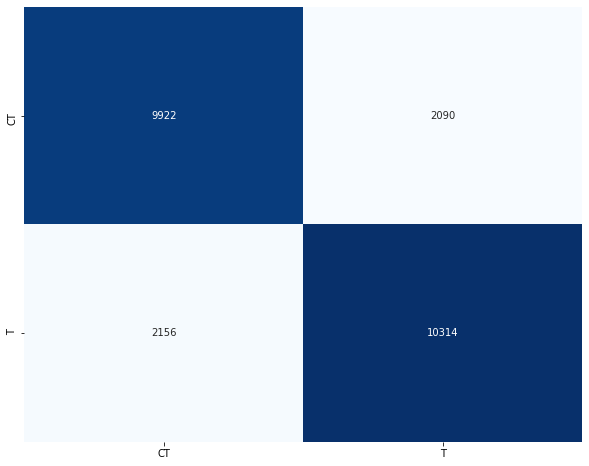

In [ ]:
dt_model = DecisionTreeClassifier(random_state=1)
dt_model.fit(X_train,y_train)
y_pred = dt_model.predict(X_test)
evaluate(y_pred, y_test)

accuracy:  0.8841189445306756
precision:  0.8947627243668552
recall:  0.8754611066559743
F1 score:  0.8850066880142679


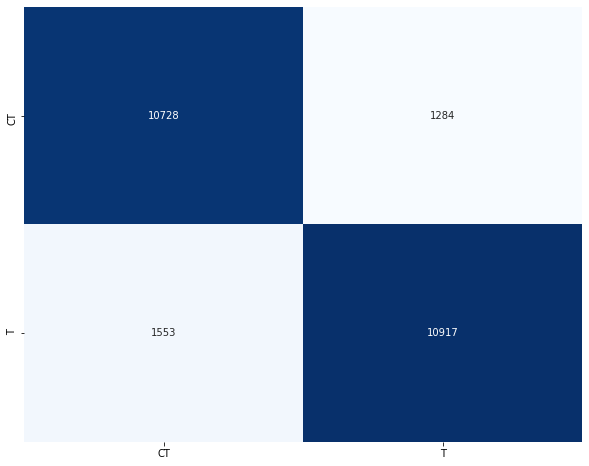

In [ ]:
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)
evaluate(y_pred, y_test)